In [1]:
import utils
import utils_peepholes
import numpy as np
import lasagne
import random
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import codecs
import cv2
from matplotlib import rc
font = {'family': 'DejaVu Sans',
        'weight': 'normal'}
rc('font', **font)

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5105)


In [2]:
args = {
    'hdim': 228,
    'depth': 1,
    'language': 'hy-AM',
    'model': 'languages/hy-AM/models/init_ortho.hdim228.depth1.seq_len100.bs50.epoch21.loss0.0078.npy',
    'seq_len': 100,
    'batch_size': 500
}

In [3]:
(char_to_index, index_to_char, vocab_size, trans_to_index, index_to_trans, trans_vocab_size) = utils.load_vocabulary(language = args['language'])

In [4]:
(test_text, trans, long_letter_reverse_mapping) = utils.load_language_data(language = args['language'], is_train = False)

In [5]:
#reload(utils)
(network_output, predict) = utils_peepholes.define_model(args['hdim'], args['depth'], trans_vocab_size = trans_vocab_size, vocab_size = vocab_size, is_train = False)

Compiling Functions ...


In [6]:
if args['model']:
        f = np.load(args['model'])
        param_values = [np.float32(f[i]) for i in range(len(f))]
        lasagne.layers.set_all_param_values(network_output, param_values)

In [7]:
def get_weight_matrix(network, csv_name, index_to_char, index_to_trans, depth):
    W = lasagne.layers.get_all_params(network)[depth].get_value()
    return W


In [8]:
w = get_weight_matrix(network_output, "residual", index_to_char, index_to_trans, -2)
b = get_weight_matrix(network_output, "residual", index_to_char, index_to_trans, -1)
print b.shape
print w.shape
w1 = get_weight_matrix(network_output, "residual", index_to_char, index_to_trans, -4)
b1 = get_weight_matrix(network_output, "residual", index_to_char, index_to_trans, -3)
print b1.shape
print w1.shape

(152,)
(300, 152)
(228,)
(456, 228)


In [9]:
for i in lasagne.layers.get_all_params(network_output):
    print i.get_value().shape

(72, 228)
(228, 228)
(228,)
(72, 228)
(228, 228)
(228,)
(72, 228)
(228, 228)
(228,)
(72, 228)
(228, 228)
(228,)
(228,)
(228,)
(228,)
(1, 228)
(1, 228)
(72, 228)
(228, 228)
(228,)
(72, 228)
(228, 228)
(228,)
(72, 228)
(228, 228)
(228,)
(72, 228)
(228, 228)
(228,)
(228,)
(228,)
(228,)
(1, 228)
(1, 228)
(456, 228)
(228,)
(300, 152)
(152,)


In [10]:
lasagne.layers.get_all_params(network_output)[-7].get_value()

array([-0.16099089,  0.29010001,  0.11662843,  0.2017466 ,  0.04164324,
       -0.07256725,  0.64217103, -0.07295529, -0.00404824,  0.34612304,
       -0.0391352 ,  0.00969558, -0.06139576,  0.13858643, -0.23408654,
       -0.08049424,  0.10139527, -0.39779577, -0.25723574, -0.19878285,
        0.01737852, -0.25959054, -0.00925664,  0.46789744, -0.14355934,
       -0.46645886,  0.22516835, -0.74890822,  0.20861368,  0.087797  ,
        0.26990402, -0.02515822,  0.25464743,  0.03013642,  0.17453174,
        0.10271278,  0.2652415 , -0.45865431, -0.23806374,  0.15869856,
        0.46643439, -0.27500302,  0.46893999, -0.05405676,  0.44183946,
       -0.0365426 ,  0.40681732, -0.01770543,  0.25536209,  0.07078157,
       -0.05243543,  0.12518729,  0.14090592, -0.09538332, -0.02131069,
        0.20566827,  0.28675914, -0.05065982,  0.51408678,  0.2357921 ,
       -0.37165895,  0.17545298, -0.24612269, -0.48536962, -0.14797157,
        0.09619074, -0.10283308, -0.10760575, -0.16639911, -0.09

In [9]:
tmp = lasagne.layers.get_all_layers(network_output)
tmp

In [10]:
w2 = get_weight_matrix(network_output, "residual", index_to_char, index_to_trans, -10)
w2.shape

(228,)

In [9]:
random_samples = 5000
x,y = [],[]
print len(test_text)

30567793


In [10]:
random_indices = set() 
while len(random_indices) < random_samples:
    v = random.randint(0,len(test_text)-100)
    p = min(test_text.find(u' ',v), test_text.find(u'\n',v))
    if p not in random_indices:
        random_indices.add(p)
        (x_tmp,y_tmp,non_valids_tmp,p,turned) = utils.gen_data(p, args['seq_len'], 1, test_text, trans, trans_to_index, char_to_index, is_train = False)
        x.append(x_tmp)
        y.append(y_tmp)
        #non_valids.append(non_valids_tmp)

In [11]:
sorted_data = sorted(zip(x,y) , key = lambda tmp: tmp[0].shape[1])

In [12]:
def get_batches(sorted_data):
    buckets = {}
    for tmp in sorted_data:
        tmp = tmp[0]
        if tmp.shape[1] in buckets.keys():
            continue
        buckets[tmp.shape[1]] = [i[0] for i in sorted_data if i[0].shape[1] == tmp.shape[1]]
    batches = []
    for i in buckets.keys():
        j = 0
        while j < len(buckets[i]):
            batches.append(np.vstack(buckets[i][j:j+args['batch_size']]))
            j += args['batch_size']
    return batches

In [13]:
batches = get_batches(sorted_data)

In [14]:
predictions = [predict(batch) for batch in batches]

In [15]:
output_layer = np.vstack([ i[0] for i in predictions])
hidden_layer = np.vstack([ i[1] for i in predictions])
concat_layer = np.vstack([ i[2] for i in predictions])
insights_forward = np.vstack([ np.vstack(i[3]) for i in predictions])
insights_backwards = np.vstack([ np.vstack(i[4]) for i in predictions])

In [16]:
del predictions, test_text

In [17]:
def split_insights(insights, dim):
    return [insights[:, i*dim:(i+1)*dim] for i in range(5)]

In [18]:
ingate_f, forgetgate_f, outgate_f, cell_input_f, cell_out_f = split_insights(insights_forward, args['hdim'])
ingate_b, forgetgate_b, outgate_b, cell_input_b, cell_out_b = split_insights(insights_backwards, args['hdim'])

In [19]:
x = np.vstack([i[0][0] for i in sorted_data])
y = np.vstack([i[1][0] for i in sorted_data])
np.mean(y.argmax(axis=1) == output_layer.argmax(axis=1))

0.99629355373748296

In [20]:
np.allclose(concat_layer, np.hstack([np.tanh(cell_out_f)*outgate_f, np.tanh(cell_out_b) * outgate_b]))

True

In [41]:
def translate_translit(translit):
    main_tmp = []
    tmp_tmp = []
    for i in range(len(translit)):
        if not translit[i] in trans_to_index.keys():
            tmp_tmp.append(translit[i])
            main_tmp.append(u'#')
        else:
            main_tmp.append(translit[i])
    translit = u''.join(main_tmp)
    tmp_x = np.zeros((1,len(translit),72), dtype = np.float32)
    for i in range(len(translit)):
        tmp_x[0, i, trans_to_index[translit[i]]] = 1.
    tmp_y = predict(tmp_x)[0]
    tmp_y = utils.one_hot_matrix_to_sentence(tmp_y, index_to_char).replace(u'\u2000','')
    for l in long_letter_reverse_mapping:
        tmp_y = tmp_y.replace(l, long_letter_reverse_mapping[l])

    c = 0
    main_tmp = []
    for i in range(len(tmp_y)):
        if tmp_y[i] == u'#' and c < len(tmp_tmp):
            main_tmp.append(tmp_tmp[c])
            c += 1
        else:
            main_tmp.append(tmp_y[i])

    tmp_y = u''.join(main_tmp)

    return tmp_y
string = u'drsic areresvel drany'
print string
print translate_translit(string)

string = u'Asum en curta, bayc de taner..'
print string
print translate_translit(string)

string = u'Na mi qani Tarekaner\nxul qucha Aysinqn shun@ barekamer...'
print string
print translate_translit(string)

string = u'apreq txeq jan , maladec ,, paroxine shnorhakalucyun shaaaat lav er,,, spasum enq hetaga zargacumnerin anhamber'
print string
print translate_translit(string)

string = u'Ete erger@ nkar sarqenq, Malevichi chyorni kvadrat@ kdarna...amen inch ,bayc ham el vochinch !!! vor vochmek chlsi dzer erger@ es meka lselu em ..apreq txerq !!!'
print string
print translate_translit(string)

string = u'nenc chi vor dzer lsac R&B pop amerikakan ergery aveli imastov en'
print string
print translate_translit(string)


string = u'es huys unem vor million ditum@ kancnes u like liq@ kunenas... mi xosq el amerikaci qrcherin nayoxnerin u vat comment groxnerin : dzer anasunneric 10000000 angam avelina lilit@'
print string
print translate_translit(string)

string = u'Hargeli Hermine, ete chgiteq te inchi hamar e naxatesvats "comments" funkcian, uremn lur orva mej mi qani million angam diteq ays tesaholovaky ev lreq dzer mej'
print string
print translate_translit(string)

string = u'Mihat harc eli Lilit Hovhannisyan@ ira martuc bajanvela ???? Ete bajanvela xii ??'
print string
print translate_translit(string)

string = u'erajshtutyune plagyat e mianshanak,,naxandz chgitem inch kaseq bayc ahavor anmit tesaholovak e,ir amboxqch mtqov!bareri vra ushadrutyun dardzreq ,,,akanja cakum! Liliti masin vochinch chunem aselu amenevin,,stex xosqs ashxatanqi masine!'
print string
print translate_translit(string)

string = u'Mijev tomsery sparvely, chenq karogh kanxatesumner anel'
print string
print translate_translit(string)









































drsic areresvel drany
դրսից առերեսվել դռանը
Asum en curta, bayc de taner..
Ասում են ցուրտա, բայց դե տաներ..
Na mi qani Tarekaner
xul qucha Aysinqn shun@ barekamer...
Նա մի քանի Տարեկաներ
խուլ քուչա Այսինքն շունը բարեկամեր...
apreq txeq jan , maladec ,, paroxine shnorhakalucyun shaaaat lav er,,, spasum enq hetaga zargacumnerin anhamber
ապրեք թղեք ջան , մալադեց ,, պարողինը շնորհակալուծյուն շաաաատ լավ էր,,, սպասում ենք հետագա զարգացումներին անհամբեր
Ete erger@ nkar sarqenq, Malevichi chyorni kvadrat@ kdarna...amen inch ,bayc ham el vochinch !!! vor vochmek chlsi dzer erger@ es meka lselu em ..apreq txerq !!!
Եթե երգերը նկար սարքենք, Մալևիչի չյոռնի քվադրատը կդառնա...ամեն ինչ ,բայց համ էլ ոչինչ !!! որ ոչմեկ չլսի ձեր երգերը ես մեկա լսելու եմ ..ապրեք տղերք !!!
nenc chi vor dzer lsac R&B pop amerikakan ergery aveli imastov en
նենց չի որ ձեր լսած R&B փոփ ամերիկական երգերը ավելի իմաստով են
es huys unem vor million ditum@ kancnes u like liq@ kunenas... mi xosq el amerikaci qrcherin nayoxnerin u v

In [ ]:
print translate_translit('')

In [ ]:
def check_substring(matrix, substring, mapping):
    row = matrix.argmax(axis=1)
    k = len(row)
    substring_indices = np.array([mapping[i] for i in substring])
    ans = np.zeros(k, dtype=np.bool)
    for i in range(len(row)):
        if row[i:i+len(substring)].shape == substring_indices.shape and np.allclose(row[i:i+len(substring)], substring_indices):
            ans[i:i+len(substring)] = 1
    return ans

In [ ]:
def fei_fei(data, trans_substring, native_substring):
    matching_list = []
    for (x, y) in data:
        k = min(len(x[0]) - len(trans_substring), len(y[0]) - len(native_substring))
        if (check_substring(x[0], trans_substring, trans_to_index)[:k] & check_substring(y[0], native_substring, char_to_index)[:k]).any():
            matching_list.append((x,y))
    return matching_list

In [ ]:
native_sub = u'\u2002թյ\u2002ն'
trans_sub = u'utyun'

In [ ]:
yevs = fei_fei(sorted_data, trans_sub, native_sub)
yevs = sorted(yevs, key = lambda d: d[0].shape[1])

In [ ]:
len(yevs)

In [ ]:
yev_batches = get_batches(yevs)

In [ ]:
predictions = [predict(batch) for batch in yev_batches]

In [ ]:
yevs_output_layer = np.vstack([ i[0] for i in predictions])
yevs_hidden_layer = np.vstack([ i[1] for i in predictions])
yevs_concat_layer = np.vstack([ i[2] for i in predictions])
yevs_insights_f = np.vstack([ np.vstack(i[3]) for i in predictions])
yevs_insights_b = np.vstack([ np.vstack(i[4]) for i in predictions])
yevs_ingate_f, yevs_forgetgate_f, yevs_outgate_f, yevs_cell_input_f, yevs_cell_out_f = split_insights(yevs_insights_f, args['hdim'])
yevs_ingate_b, yevs_forgetgate_b, yevs_outgate_b, yevs_cell_input_b, yevs_cell_out_b = split_insights(yevs_insights_b, args['hdim'])

In [ ]:
print yevs_hidden_layer.shape
j = 0
yevs_cell_out_b_list = []
yevs_cell_out_f_list = []
yevs_hidden_layer_list = []
yevs_concat_layer_list = []
for i in yevs:
    length = len(i[0][0])
    yevs_cell_out_b_list.append(yevs_cell_out_b[j:j+length])
    yevs_cell_out_f_list.append(yevs_cell_out_f[j:j+length])
    yevs_hidden_layer_list.append(yevs_hidden_layer[j:j+length])
    yevs_concat_layer_list.append(yevs_concat_layer[j:j+length])
    j += length

In [ ]:
[i for i in range(len(yevs)) if (check_substring(yevs[i][0][0], trans_sub, trans_to_index) | check_substring(yevs[i][0][0], u'utyan', trans_to_index)).sum() > 15]

In [ ]:
print utils.one_hot_matrix_to_sentence(yevs[10][1][0], index_to_char)
print utils.one_hot_matrix_to_sentence(yevs[10][0][0], index_to_trans)

In [ ]:
yev_backward_means = np.zeros(228)
backward_means = cell_out_b.mean(axis=0) #np.zeros(228) 
yev_forward_means = np.zeros(228)
forward_means = cell_out_f.mean(axis=0) # np.zeros(228)
hidden_layer_means = hidden_layer.mean(axis=0) # np.zeros(300)
yev_hidden_layer_means = np.zeros(300)
concat_layer_means = concat_layer.mean(axis=0) #np.zeros(456)
yev_concat_layer_means = np.zeros(456)
c = 0
for i in range(len(yevs)):
    mask = (check_substring(yevs[i][0][0], trans_sub, trans_to_index) & \
            check_substring(yevs[i][1][0], native_sub, char_to_index))
    c += mask.sum()
    
    yev_backward_means += yevs_cell_out_b_list[i][mask].sum(axis=0)
#    backward_means += yevs_cell_out_b_list[i][~(check_substring(yevs[i][0][0], trans_sub, trans_to_index) & \
#                            check_substring(yevs[i][1][0], native_sub, char_to_index))].mean(axis=0)
    yev_forward_means += yevs_cell_out_f_list[i][mask].sum(axis=0)
#    forward_means += yevs_cell_out_f_list[i][~(check_substring(yevs[i][0][0], trans_sub, trans_to_index) & \
#                            check_substring(yevs[i][1][0], native_sub, char_to_index))].mean(axis=0)
    yev_hidden_layer_means += yevs_hidden_layer_list[i][mask].sum(axis=0)
#    hidden_layer_means += yevs_hidden_layer_list[i][~(check_substring(yevs[i][0][0], trans_sub, trans_to_index) & \
#                            check_substring(yevs[i][1][0], native_sub, char_to_index))].mean(axis=0)
    yev_concat_layer_means += yevs_concat_layer_list[i][mask].sum(axis=0)


In [ ]:
yev_backward_means /= c
#backward_means /= len(yevs)
yev_forward_means /= c
#forward_means /= len(yevs)
yev_hidden_layer_means /= c
#hidden_layer_means /= len(yevs)
yev_concat_layer_means /= c
#concat_layer_means /= len(yevs)

In [ ]:
print sorted(np.abs(yev_backward_means - backward_means))[-10:]
print sorted(np.abs(yev_forward_means - forward_means))[-10:]
print sorted(np.abs(yev_hidden_layer_means - hidden_layer_means))[-10:]
print sorted(np.abs(yev_concat_layer_means - concat_layer_means))[-10:]

In [ ]:
print np.argsort(np.abs(yev_backward_means - backward_means))[-10:]
print np.argsort(np.abs(yev_forward_means - forward_means))[-10:]
print np.argsort(np.abs(yev_hidden_layer_means - hidden_layer_means))[-10:]
print np.argsort(np.abs(yev_concat_layer_means - concat_layer_means))[-10:]

In [ ]:
taretiv = 939

cell_num_backwards = 23
cell_num_forward = 121
hidden_num = 37
concat_num = 78

inp = utils.one_hot_matrix_to_sentence(yevs[taretiv][0], index_to_trans)
out = utils.one_hot_matrix_to_sentence(yevs[taretiv][1], index_to_char)
#print inp, out
b_tmp = yevs_cell_out_b_list[taretiv][:,cell_num_backwards]
f_tmp = yevs_cell_out_f_list[taretiv][:,cell_num_forward]
h_tmp = yevs_hidden_layer_list[taretiv][:, hidden_num]
c_tmp = yevs_concat_layer_list[taretiv][:, concat_num]


color_backwards = (np.tanh((b_tmp - b_tmp.mean()) / b_tmp.std()) + 1 ) / 2
color_forward = (np.tanh((f_tmp - f_tmp.mean()) / f_tmp.std()) + 1 ) / 2
color_hidden = (np.tanh((h_tmp - h_tmp.mean()) / h_tmp.std()) + 1 ) / 2
color_concat = (np.tanh((c_tmp - c_tmp.mean()) / c_tmp.std()) + 1 ) / 2
# print color_forward
# print color_backwards
inp = inp.replace(' ','.')
out = out.replace(' ','.').replace(u'\u2000','_')
for tmp in long_letter_reverse_mapping:
    out = out.replace(tmp, long_letter_reverse_mapping[tmp][-1])
for i in range(len(out)):
    plt.text(0 + i*0.08, 0.8, out[i], size='xx-large', backgroundcolor=(1, 0.5, 0.5))
for i in range(len(inp)):
    plt.text(0 + i*0.08, 0.5, inp[i], size='xx-large', backgroundcolor=(1, 1-color_backwards[i], 1-color_backwards[i]))
for i in range(len(inp)):
    plt.text(0 + i*0.08, 0.2, inp[i], size='xx-large', backgroundcolor=(1, 1-color_forward[i], 1-color_forward[i]))
for i in range(len(inp)):
    plt.text(0 + i*0.08, -0.1, inp[i], size='xx-large', backgroundcolor=(1, 1-color_hidden[i], 1-color_hidden[i]))
for i in range(len(inp)):
    plt.text(0 + i*0.08, -0.4, inp[i], size='xx-large', backgroundcolor=(1, 1-color_concat[i], 1-color_concat[i]))

plt.axis('off');

In [21]:
def compute_histogram_scores(activations):
    #return bhattacharyya_distance(activations)
    method_flag = cv2.cv.CV_COMP_BHATTACHARYYA
    scores = [None] * activations[0].shape[1]
    l = min(activations[0].min(), activations[1].min())
    r = max(activations[0].max(), activations[1].max())
    #l= -100
    #r = 100
    print 'histogram range:',l,r
    for neuron in np.arange(activations[0].shape[1]):
        bins1 = np.histogram(activations[0][:, neuron],bins=1000, normed=True, range=(l,r))
        bins2 = np.histogram(activations[1][: , neuron], bins=1000, normed=True, range=(l,r))
        #scores[neuron] = np.sum(np.minimum(bins1[0],bins2[0]))# / np.sum(np.maximum(bins1[0],bins2[0])) 
        #scores[neuron] = abs((bins1[0] * bins1[1][1:]).sum()/50 - (bins2[0] * bins2[1][1:]).sum()/50)
        scores[neuron] = -1. * cv2.compareHist(bins1[0].astype(np.float32), bins2[0].astype(np.float32),\
                                         method_flag)
    return scores

In [22]:
"""
def compute_signed_scores(activations_f, activations_b, indices_f, indices_b, mask1, mask2):
    f_scores = np.array(compute_histogram_scores([activations_f[mask1], activations_f[mask2]]))
    b_scores = np.array(compute_histogram_scores([activations_b[mask1], activations_b[mask2]]))
    # compute the sign of the score based on mask2 only
#     f_scores *= np.sign(activations_f[mask2].mean(axis=0))
#     b_scores *= np.sign(activations_b[mask2].mean(axis=0))
    scores = np.hstack([f_scores[indices_f], b_scores[indices_b-args['hdim']]])
    return scores
""";

In [23]:
def compute_signed_scores(activations, indices, mask1, mask2):
    scores = np.array(compute_histogram_scores([activations[mask1], activations[mask2]]))
#   compute the sign of the score based on mask2 only
#   scores *= np.sign(activations[mask2].mean(axis=0))
    return scores[indices]

In [24]:
def plot_neurons_with_labels(text, data, neuron_names, vmin, vmax, r, y, color_threshold=0.5, x_range=(-0.5, 1.5)):
    plt.annotate(text, (1.6, y), fontsize='x-large')
    positions = zip(np.linspace(x_range[0], x_range[1], len(data)), [y]*len(data))
    plt.scatter(*zip(*positions), c = data, s=r*r, \
                cmap='RdYlGn', edgecolors='none', vmin=vmin, vmax=vmax)
    
    for ( (text_x, text_y), neuron, score) in zip(positions, neuron_names, data):
        color = 'Black' if abs(score) < color_threshold else 'White'
        plt.annotate(str(neuron), (text_x-0.025, text_y), fontsize='x-large', color=color)  

In [25]:
input_char_index = trans_to_index[u's']
output_char_index = char_to_index[u'շ']
input_char_index = trans_to_index[u'c']
output_char_index = char_to_index[u'ծ']
input_char_index = trans_to_index[u'T']
output_char_index = char_to_index[u'Ճ']
input_char_index = trans_to_index[u't']
output_char_index = char_to_index[u'ճ']
input_char_index = trans_to_index[u'e']
output_char_index = char_to_index[u'և']
input_char_index = trans_to_index[u'v']
output_char_index = char_to_index[u'\u2000']
input_char_index = trans_to_index[u'd']
output_char_index = char_to_index[u'ձ']
input_char_index = trans_to_index[u'q']
output_char_index = char_to_index[u'ք']
input_char_index = trans_to_index[u'r']
output_char_index = char_to_index[u'ր']
input_char_index = trans_to_index[u's']
output_char_index = char_to_index[u'\u2000']
input_char_index = trans_to_index[u'z']
output_char_index = char_to_index[u'ձ']
input_char_index = trans_to_index[u'e']
output_char_index = char_to_index[u'\u2000']
input_char_index = trans_to_index[u'k']
output_char_index = char_to_index[u'խ']
input_char_index = trans_to_index[u'h']
output_char_index = char_to_index[u'\u2000']
input_char_index = trans_to_index[u't']
output_char_index = char_to_index[u'ծ']
#output_neuron_number = 4
hidden_neuron_number = 12
concat_neuron_number = 10

In [26]:
input_is_fixed = (x.argmax(axis=1) == input_char_index)
output_is_fixed = (y.argmax(axis=1) == output_char_index)
next_to_input = np.hstack([np.array(False), input_is_fixed])[:-1]
next_to_output = np.hstack([np.array(False), output_is_fixed])[:-1]
prev_to_input = np.hstack([input_is_fixed, np.array(False)])[1:]
prev_to_output = np.hstack([output_is_fixed, np.array(False)])[1:]

In [27]:
t_t_concat = compute_histogram_scores([concat_layer[input_is_fixed & ~output_is_fixed], \
                                       concat_layer[input_is_fixed & output_is_fixed]])

t_t_concat_l = t_t_concat[:args['hdim']]
t_t_concat_r = t_t_concat[args['hdim']:]

concats_l = zip(np.argsort(t_t_concat_l)[:concat_neuron_number], np.sort(t_t_concat_l)[:concat_neuron_number])
concats_r = zip(np.argsort(t_t_concat_r)[:concat_neuron_number] + args['hdim'], np.sort(t_t_concat_r)[:concat_neuron_number])
concats_l.sort()
concats_r.sort()
concats_l, concat_scores_l = zip(*concats_l)
concats_r, concat_scores_r = zip(*concats_r)

concat_scores_l = np.array(concat_scores_l)
concat_scores_r = np.array(concat_scores_r)
# concat_scores_l *= np.sign(concat_layer[input_is_fixed & output_is_fixed][:,concats_l].mean(axis=0))
concat_scores_l = concat_scores_l
# concat_scores_r *= np.sign(concat_layer[input_is_fixed & output_is_fixed][:,concats_r].mean(axis=0))
concat_scores_r = concat_scores_r

concats = np.concatenate((concats_l, concats_r))
concat_scores = np.concatenate((concat_scores_l, concat_scores_r))
#concats, concat_scores

t_t_hidden = compute_histogram_scores([hidden_layer[input_is_fixed & ~output_is_fixed], \
                                       hidden_layer[input_is_fixed & output_is_fixed]])
hiddens = zip(np.argsort(t_t_hidden)[:hidden_neuron_number], np.sort(t_t_hidden)[:hidden_neuron_number])
hiddens.sort()
hiddens, hidden_scores = zip(*hiddens)

hidden_scores = np.array(hidden_scores)
# hidden_scores *= np.sign(hidden_layer[input_is_fixed & output_is_fixed][:,hiddens].mean(axis=0))
hidden_scores = hidden_scores

#hiddens, hidden_scores

t_t_out = compute_histogram_scores([output_layer[input_is_fixed & ~output_is_fixed], \
                                    output_layer[input_is_fixed & output_is_fixed]])

print t_t_out
output_neuron_number = sum(np.abs(t_t_out) > 0.01)
outs = zip(np.argsort(t_t_out)[:output_neuron_number], np.sort(t_t_out)[:output_neuron_number])
outs.sort()
outs, out_scores = zip(*outs)

out_scores = np.array(out_scores)
# out_scores *= np.sign(output_layer[input_is_fixed & output_is_fixed][:,outs].mean(axis=0))
out_scores = out_scores

#outs, out_scores

cell_scores_f = compute_signed_scores(cell_out_f, concats[:len(concats)/2],
                                      input_is_fixed & ~output_is_fixed,
                                      input_is_fixed & output_is_fixed)

cell_scores_b = compute_signed_scores(cell_out_b, concats[len(concats)/2:] - args['hdim'],
                                      input_is_fixed & ~output_is_fixed,
                                      input_is_fixed & output_is_fixed)

cell_scores = np.hstack([cell_scores_f, cell_scores_b])



outgate_scores_f = compute_signed_scores(outgate_f, concats[:len(concats)/2],
                                         input_is_fixed & ~output_is_fixed,
                                         input_is_fixed & output_is_fixed)

outgate_scores_b = compute_signed_scores(outgate_b, concats[len(concats)/2:] - args['hdim'],
                                         input_is_fixed & ~output_is_fixed,
                                         input_is_fixed & output_is_fixed)

outgate_scores = np.hstack([outgate_scores_f, outgate_scores_b])



ingate_scores_f = compute_signed_scores(ingate_f, concats[:len(concats)/2],
                                        input_is_fixed & ~output_is_fixed,
                                        input_is_fixed & output_is_fixed)

ingate_scores_b = compute_signed_scores(ingate_b, concats[len(concats)/2:] - args['hdim'],
                                        input_is_fixed & ~output_is_fixed,
                                        input_is_fixed & output_is_fixed)

ingate_scores = np.hstack([ingate_scores_f, ingate_scores_b])



cell_input_scores_f = compute_signed_scores(cell_input_f, concats[:len(concats)/2],
                                            input_is_fixed & ~output_is_fixed,
                                            input_is_fixed & output_is_fixed)

cell_input_scores_b = compute_signed_scores(cell_input_b, concats[len(concats)/2:] - args['hdim'],
                                            input_is_fixed & ~output_is_fixed,
                                            input_is_fixed & output_is_fixed)

cell_input_scores = np.hstack([cell_input_scores_f, cell_input_scores_b])



forgetgate_scores_f = compute_signed_scores(forgetgate_f, concats[:len(concats)/2],
                                            input_is_fixed & ~output_is_fixed,
                                            input_is_fixed & output_is_fixed)

forgetgate_scores_b = compute_signed_scores(forgetgate_b, concats[len(concats)/2:] - args['hdim'],
                                            input_is_fixed & ~output_is_fixed,
                                            input_is_fixed & output_is_fixed)

forgetgate_scores = np.hstack([forgetgate_scores_f, forgetgate_scores_b])



next_cell_scores_f = compute_signed_scores(cell_out_f, concats[:len(concats)/2],
                                           prev_to_input & ~prev_to_output,
                                           prev_to_input & prev_to_output)

next_cell_scores_b = compute_signed_scores(cell_out_b, concats[len(concats)/2:] - args['hdim'],
                                           next_to_input & ~next_to_output,
                                           next_to_input & next_to_output)

next_cell_scores = np.hstack([next_cell_scores_f,next_cell_scores_b])



histogram range: -0.958167 0.988005
histogram range: -1.0 1.0
histogram range: 2.00673e-26 1.0
[-0.28486292508465305, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.9994174084225401, -0.0, -0.0, -0.1045281764325582, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.46954571378038024, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0

In [28]:
output_neuron_number

6

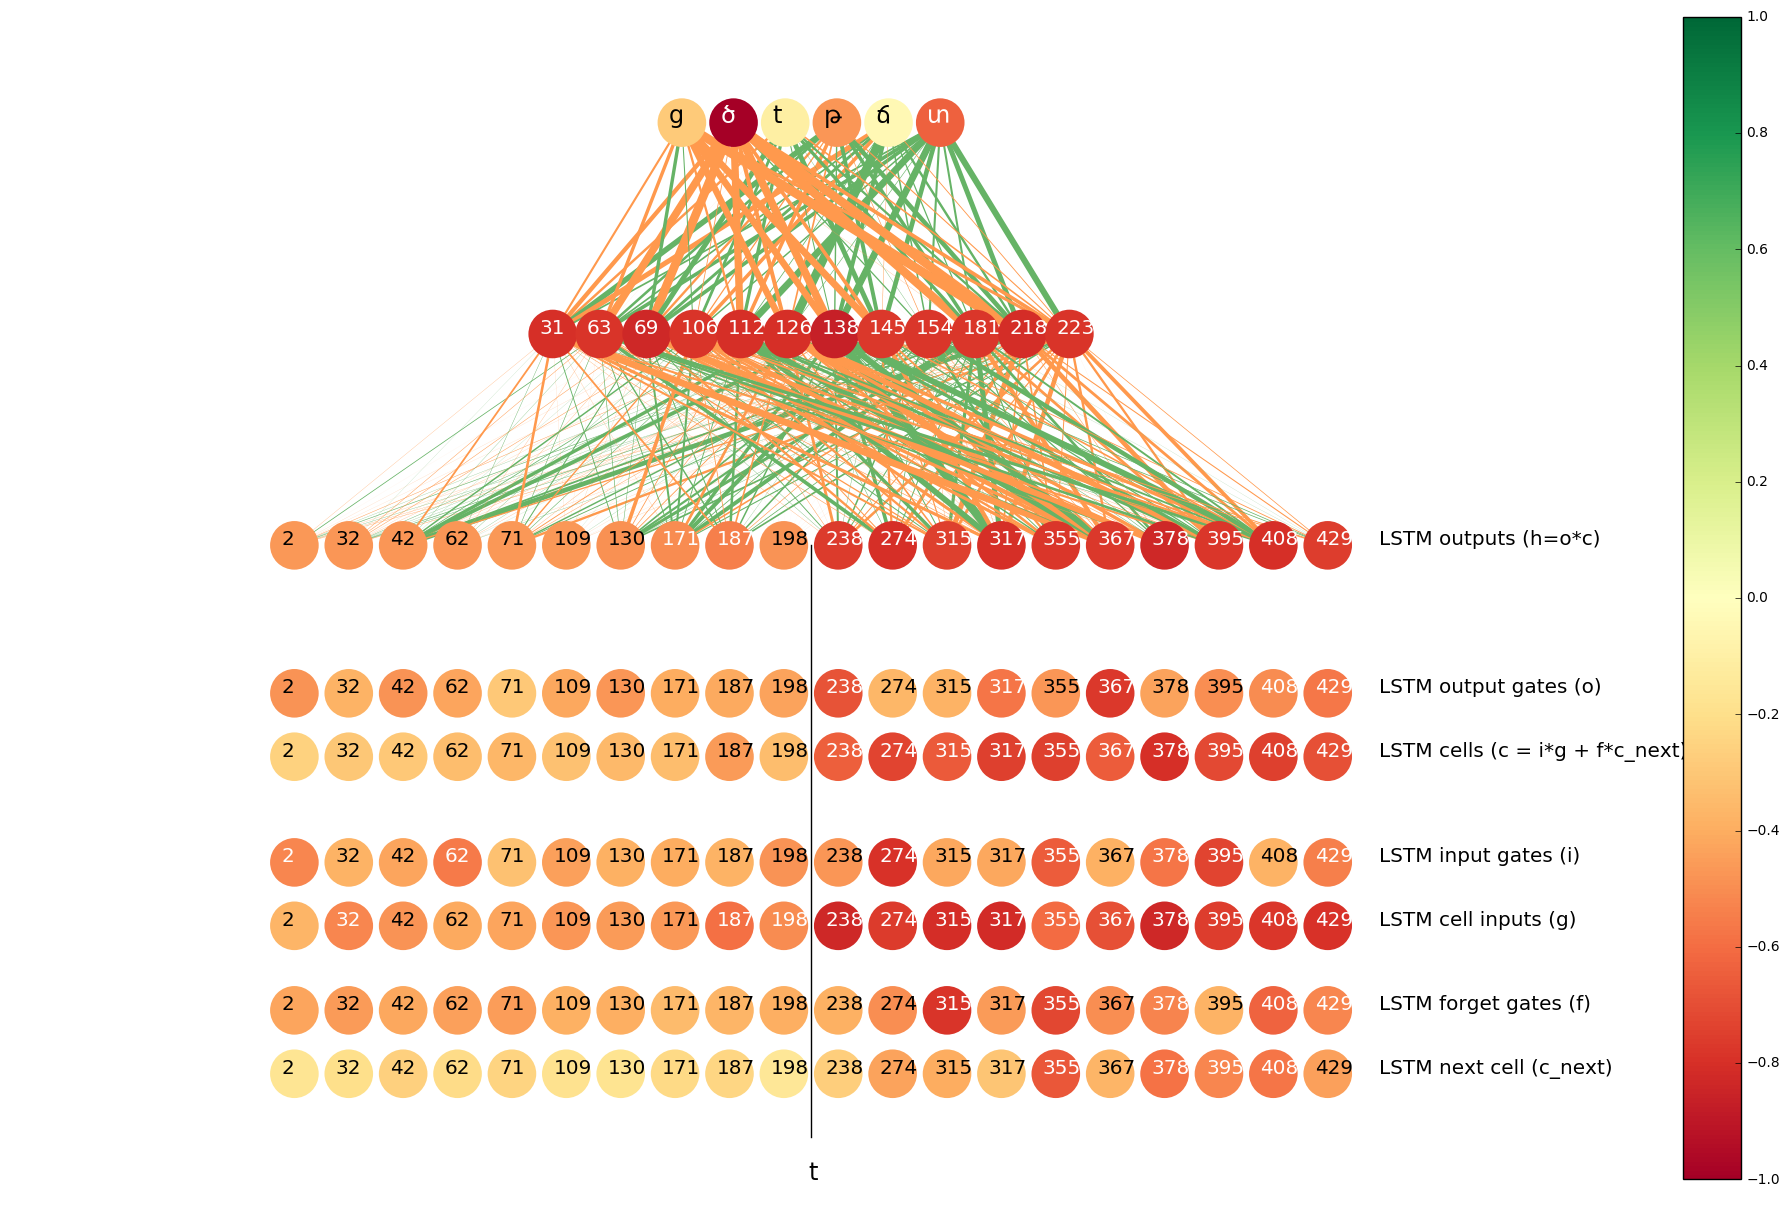

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(25,15))
r = 35.
vmin = -1
vmax = 1
means = hidden_layer[input_is_fixed & output_is_fixed][:,hiddens].mean(axis=0)
for i in range(len(hiddens)):
    for j in range(len(outs)):
        impact = w[hiddens[i],outs[j]] * means[i]
        plt.plot([i / float(len(hiddens)-1), 1./4 + j/(2.*(len(outs)-1))], [0, 1], 'k-', lw=abs(impact)*10, zorder = 0, \
                 color=( (1, 0.6, 0.3) if impact > 0 else (0.4,0.7,0.4))) 
        
means = concat_layer[input_is_fixed & output_is_fixed][:,concats].mean(axis=0)
for i in range(len(concats)):
    for j in range(len(hiddens)):
        impact = w1[concats[i],hiddens[j]] * means[i]
        plt.plot([-0.5 + 2* i/ float(len(concats)-1), j / float(len(hiddens)-1)], [-1, 0], 'k-', zorder = 0,\
                 lw=abs(impact)*10, color=( (1, 0.6, 0.3) if impact > 0 else (0.4,0.7,0.4)))

# Output layer
positions = zip(np.linspace(1./4, 3./4, len(outs), endpoint = 'True'),[1]*len(outs))
plt.scatter(*zip(*positions), s=r*r, c = out_scores, \
            cmap='RdYlGn', edgecolors='none' , vmin= vmin, vmax= vmax)

for ( (text_x, text_y) , neuron, score) in zip(positions, outs, out_scores):
    color = 'Black' if abs(score) < 0.5 else 'White'
    plt.annotate(index_to_char[neuron] if index_to_char[neuron] != u'\u2000' else '__', \
                 (text_x-0.025, text_y), fontsize='xx-large', color=color)

# Last dense layer
positions = zip(np.linspace(0,1,len(hiddens)), [0]*len(hiddens))
plt.scatter(*zip(*positions), c = hidden_scores, s=r*r, \
            cmap='RdYlGn', edgecolors='none', vmin=vmin, vmax=vmax)

for ( (text_x, text_y) , neuron, score) in zip(positions, hiddens, hidden_scores):
    color = 'Black' if abs(score) < 0.5 else 'White'
    plt.annotate(str(neuron), (text_x-0.025, text_y), fontsize='x-large', color=color)
    
plot_neurons_with_labels("LSTM outputs (h=o*c)", concat_scores, concats, vmin, vmax, r, -1)
plot_neurons_with_labels("LSTM output gates (o)", outgate_scores, concats, vmin, vmax, r, -1.7)
plot_neurons_with_labels("LSTM cells (c = i*g + f*c_next)", cell_scores, concats, vmin, vmax, r, -2)
plot_neurons_with_labels("LSTM input gates (i)", ingate_scores, concats, vmin, vmax, r, -2.5)
plot_neurons_with_labels("LSTM cell inputs (g)", cell_input_scores, concats, vmin, vmax, r, -2.8)
plot_neurons_with_labels("LSTM forget gates (f)", forgetgate_scores, concats, vmin, vmax, r, -3.2)
plot_neurons_with_labels("LSTM next cell (c_next)", next_cell_scores, concats, vmin, vmax, r, -3.5)

plt.plot((0.5,0.5),(-3.8,-1),color='black')
plt.annotate(index_to_trans[input_char_index], (0.495, -4), fontsize='xx-large', color='black')

axs.set_ylim([-4,1.5]);
axs.axis('off');

plt.colorbar();

In [43]:
hidden_scores

array([-0.81396141, -0.81151899, -0.81059575, -0.85080211, -0.84132112,
       -0.84427292, -0.82322339, -0.86982118, -0.82450612, -0.8207327 ,
       -0.8448941 , -0.82256808])

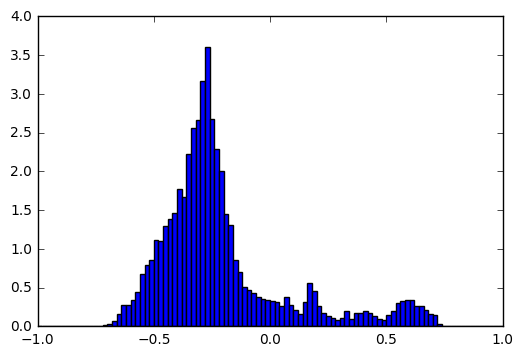

In [82]:
plt.hist(concat_layer[input_is_fixed & ~output_is_fixed][:, 378], bins=100, normed=True, range=(-1,1));
plt.ylim([0,4]);

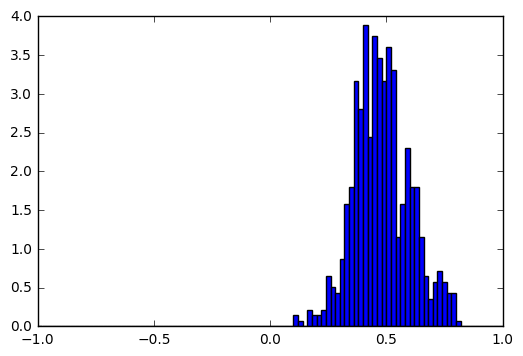

In [64]:
plt.hist(concat_layer[input_is_fixed & output_is_fixed][:, 378], bins=100, normed=True, range=(-1,1));
plt.ylim([0,4]);

In [ ]:
print index_to_char[output_char_index]

In [ ]:
plt.hist(hidden_layer[input_is_fixed & ~output_is_fixed][:, 138], bins=100, normed=True, range=(-1,1));

In [ ]:
plt.hist(hidden_layer[input_is_fixed & output_is_fixed][:, 138], bins=100, normed=True, range=(-1,1));

In [ ]:
cell_input_b.max()

In [ ]:
378-228

In [ ]:
outs

In [ ]:
print index_to_char[0]

In [ ]:
out_scores

# Neuron -> Specialization

In [30]:
def is_possible(x, y, input_char, output_char):
    i_is_fixed = (x.argmax(axis=1) == trans_to_index[input_char])
    o_is_fixed = (y.argmax(axis=1) == char_to_index[output_char])
    return (np.sum( i_is_fixed & o_is_fixed ) > 300) and ( np.sum(i_is_fixed & ~o_is_fixed) > 300)

In [31]:
# possible_outcomes = { input_char : [output_char for output_char in char_to_index.keys() if is_possible(x, y, input_char, output_char)]
#                     for input_char in trans_to_index.keys()}

In [32]:
is_possible(x,y,'t',u'թ')

True

In [33]:
possible_outcomes = { output_char : list(set([input_seq[0] for input_seq in trans[output_char].keys()]))
                     for output_char in trans.keys()}

In [34]:
possible_outcomes[u'#'] = []
possible_outcomes[u'\u2000'] = []
for output_char in trans.keys():
    for input_seq in trans[output_char].keys():
        for c in input_seq[1:]:
            possible_outcomes[u'\u2000'].append(c)
possible_outcomes[u'\u2000'] = list(set(possible_outcomes[u'\u2000']))

for output_char in char_to_index.keys():
    if output_char not in possible_outcomes.keys():
        possible_outcomes[output_char] = [output_char]

In [35]:
for l in long_letter_reverse_mapping.keys():
    possible_outcomes[l] = possible_outcomes[long_letter_reverse_mapping[l]]
    possible_outcomes.pop(long_letter_reverse_mapping[l], None)

In [36]:
for output_char in possible_outcomes.keys():
    print output_char
    possible_outcomes[output_char] = [input_char for input_char in possible_outcomes[output_char] \
                                      if is_possible(x, y, input_char, output_char)]

ց
 
օ
 
 
,
0
Բ
4
Զ
8
Ժ
Ծ
@
Ղ
D
Ն
H
Պ
L
Վ
P
Ւ
T
Ֆ
X
բ
d
զ
h
ժ
l
ծ
p
ղ
t
ն
x
պ
վ
 
ւ
ֆ
#
Ա
3
Ե
7
Թ
;
Խ
Ձ
C
Յ
G
Չ
K
Ս
O
Ց
S
Օ
ա
c
ե
g
թ
k
խ
o
ձ
s
յ
չ
ս
փ
 
և


i
&
2
Դ
6
Ը
:
Լ
Հ
B
Մ
F
Ո
J
Ռ
N
Ր
R
Ք
V
Z
b
դ
f
ը
j
լ
n
հ
r
մ
v
ո
z
ռ
 
ր
ք
	
-
1
Գ
5
Է
9
Ի
Կ
A
Ճ
E
Շ
I
Ջ
M
Տ
Q
Փ
U
Y
a
գ
e
է
ի
m
կ
q
ճ
u
շ
y
ջ
տ


In [37]:
possible_outcomes[u'ծ']

[u'c', u't']

In [38]:
neuron_number = 378 #char_to_index[u'ծ']
print neuron_number

378


In [80]:
possible_outcomes[u'ծ']

[u'c', u't']

In [82]:
def get_helps(neuron, layer, possible_outcomes):
    print neuron
    method_flag = cv2.cv.CV_COMP_BHATTACHARYYA
    l = []
    for output_char in possible_outcomes.keys():
        for input_char in possible_outcomes[output_char]:        
            input_is_fixed = (x.argmax(axis=1) == trans_to_index[input_char])
            output_is_fixed = (y.argmax(axis=1) == char_to_index[output_char])

            bins1 = np.histogram(layer[input_is_fixed & ~output_is_fixed][:, neuron],
                                 bins=1000, normed=True, range=(-1,1))
            bins2 = np.histogram(layer[input_is_fixed & output_is_fixed][:, neuron],
                                 bins=1000, normed=True, range=(-1,1))

            dist = cv2.compareHist(bins1[0].astype(np.float32), bins2[0].astype(np.float32), method_flag)
            l.append(dist)
    return l

In [40]:
output_helps = np.hstack([np.array(get_helps(neuron, output_layer)) for neuron in range(152)])
print output_helps.shape
hidden_helps = np.hstack([np.array(get_helps(neuron, hidden_layer)) for neuron in range(228)])
print hidden_helps.shape
concat_helps = np.hstack([np.array(get_helps(neuron, concat_layer)) for neuron in range(228*2)])
print concat_helps.shape


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
(8816,)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


In [56]:
method_flag = cv2.cv.CV_COMP_BHATTACHARYYA
l = []
for output_char in possible_outcomes.keys():
    for input_char in possible_outcomes[output_char]:        
        input_is_fixed = (x.argmax(axis=1) == trans_to_index[input_char])
        output_is_fixed = (y.argmax(axis=1) == char_to_index[output_char])
        
        bins1 = np.histogram(concat_layer[input_is_fixed & ~output_is_fixed][:, neuron_number],
                             bins=1000, normed=True, range=(-1,1))
        bins2 = np.histogram(concat_layer[input_is_fixed & output_is_fixed][:, neuron_number],
                             bins=1000, normed=True, range=(-1,1))
        dist = cv2.compareHist(bins1[0].astype(np.float32), bins2[0].astype(np.float32), method_flag)
        if not np.isnan(dist):
            l.append((dist, input_char, output_char))
l.sort()
l[::-1][:10]

[(0.8885219617771889, u'd', u'\u0571'),
 (0.8315603243534044, u't', u'\u056e'),
 (0.8112894545843433, u't', u'\u0581'),
 (0.8029564207073848, u'k', u'\u056d'),
 (0.7734923386950945, u'y', u'\u0587'),
 (0.739556872401278, u'T', u'\u054f'),
 (0.6967652926434268, u'd', u'\u0564'),
 (0.6831587569377575, u'c', u'\u0579'),
 (0.6726020225541316, u'e', u'\u0568'),
 (0.6705544855492412, u'S', u'\u054d')]

In [50]:
print u'\u0587'

և


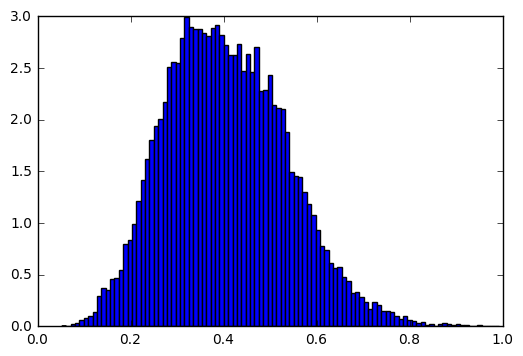

In [51]:
plt.hist(concat_helps, bins=100, normed=True);


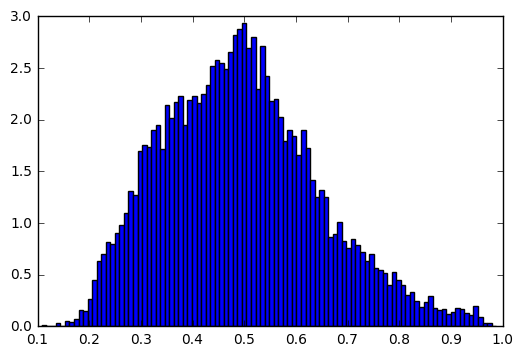

In [52]:
plt.hist(hidden_helps, bins=100,normed=True);

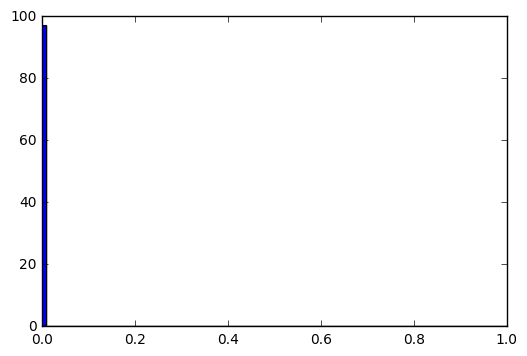

In [53]:
plt.hist(output_helps, bins=100,normed=True);

In [58]:
concat_helps.mean(), hidden_helps.mean()

(0.40639202246631539, 0.4917460740504937)

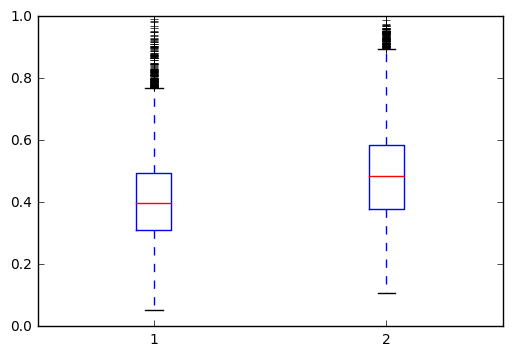

In [76]:
plt.boxplot([concat_helps,hidden_helps]);

In [84]:
output_helps_ts = np.hstack([np.array(get_helps(neuron, output_layer,{u'ծ':['t']})) for neuron in range(152)])
print output_helps_ts.shape
hidden_helps_ts = np.hstack([np.array(get_helps(neuron, hidden_layer,{u'ծ':['t']})) for neuron in range(228)])
print hidden_helps_ts.shape
concat_helps_ts = np.hstack([np.array(get_helps(neuron, concat_layer,{u'ծ':['t']})) for neuron in range(228*2)])
print concat_helps_ts.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
(152,)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
1

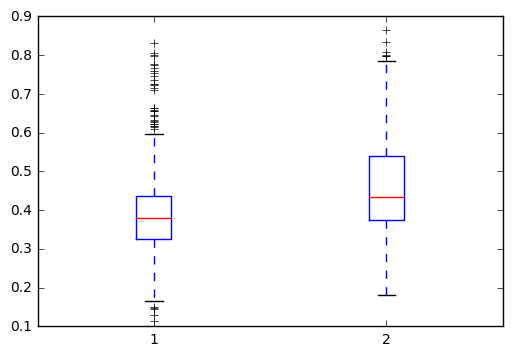

In [90]:
plt.boxplot([concat_helps_ts,hidden_helps_ts]);

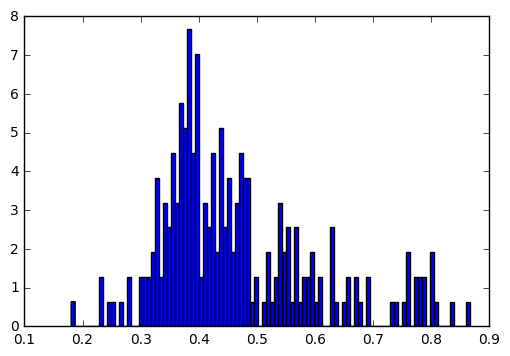

In [88]:
plt.hist(hidden_helps_ts, bins=100,normed=True);

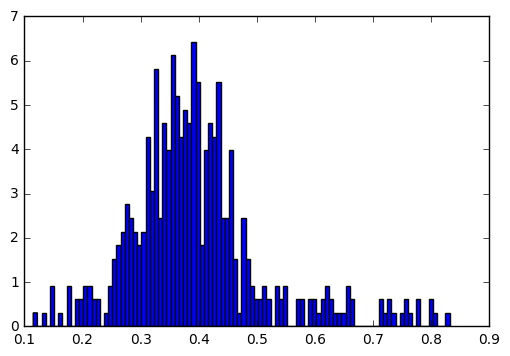

In [89]:
plt.hist(concat_helps_ts, bins=100,normed=True);